# Tutorial: Ensemble Methods

Tutorial to the class [Ensemble Methods](8_ensemble_methods.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Use ensemble methods to best predict the regional electricity demand in France;
- Control the complexity parameter(s) of each ensemble method to avoid overfitting;
- Compare the skills of different methods.
</div>

## Getting ready

### Loading the demand data

Let us load the regional electricity demand data as in [Tutorial: Supervised Learning Problem and Least Squares](2_tutorial_supervised_learning_problem_ols.ipynb).

In [1]:
# Path manipulation module
from pathlib import Path
# Numerical analysis module
import numpy as np
# Formatted numerical analysis modules
import pandas as pd
import xarray as xr
# Plot module
import matplotlib.pyplot as plt
# Default colors
RC_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Matplotlib configuration
plt.rc('font', size=14)

# Set data directory
data_dir = Path('data')

# Set keyword arguments for pd.read_csv
kwargs_read_csv = dict()

# Set first and last years
FIRST_YEAR = 2014
LAST_YEAR = 2019

# Define electricity demand filepath and label
dem_filename = 'reseaux_energies_demand_demand.csv'
dem_filepath = Path(data_dir, dem_filename)
dem_label = 'Electricity consumption (MWh)'

# Read hourly demand data averaged over each region
df_dem = pd.read_csv(
    dem_filepath, index_col=0, header=0, parse_dates=True)
region_rename = {
    'Auvergne-Rhône-Alpes': 'Auvergne-Rhône-Alpes',
    'Bourgogne-Franche-Comté': 'Bourgogne-Franche-Comté',
    'Bretagne': 'Bretagne',
    'Centre-Val de Loire': 'Centre-Val de Loire',
    'Grand Est': 'Grand Est',
    'Hauts-de-France': 'Hauts-de-France',
    'Île-de-France': 'Ile-de-France',
    'Normandie': 'Normandie',
    'Nouvelle-Aquitaine': 'Nouvelle-Aquitaine',
    'Occitanie': 'Occitanie',
    'Pays de la Loire': 'Pays-de-la-Loire',
    "Provence-Alpes-Côte d'Azur": 'PACA'
}
df_dem.columns = [region_rename[c] for c in df_dem.columns]
df_dem.index = df_dem.index.tz_localize(None)

### Loading the climate data

Let us load climate data for France and average it over regions to use it as input to predict the demand.

In addition to the surface temperature (in °C), we also load the:
- surface density (kg/m3)
- surface downward radiation (in W/m2),
- surface specific humidity and
- surface wind (in m/s).

In [2]:
# Directories where you saved the data
data_dir_climate = Path('../../../data/projects/climate_france')
                        
# Template filenames
filename_mask = 'mask_datagouv_french_regions_merra2_Nx_France.nc'
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'
temp_label = 'Temperature (°C)'

# Read grid point-region mask
filepath_mask = Path(data_dir_climate, filename_mask)
ds_mask = xr.load_dataset(filepath_mask)
da_mask = ds_mask['mask']

def get_regional_climate(variable_name):
    filename = filename_climate.format(variable_name)
    filepath = Path(data_dir_climate, filename)
    da_climate = xr.load_dataset(filepath)
    da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
    da_climate_reg['region'] = ds_mask['region'].values
    
    return da_climate_reg

# Read a climate variable and plot its mean over time
ds_clim = get_regional_climate('surface_temperature') - 273.15
ds_clim = ds_clim.merge(get_regional_climate('surface_density'))
ds_clim = ds_clim.merge(get_regional_climate('surface_downward_radiation'))
ds_clim = ds_clim.merge(get_regional_climate('surface_specific_humidity'))
ds_clim = ds_clim.merge(get_regional_climate('zonal_wind'))
ds_clim = ds_clim.merge(get_regional_climate('meridional_wind'))
ds_clim['wind_speed'] = np.sqrt(ds_clim['zonal_wind']**2 +
                                ds_clim['meridional_wind']**2)
ds_clim['wind_direction'] = np.arctan2(ds_clim['meridional_wind'],
                                       ds_clim['zonal_wind'])
variable_names = list(ds_clim)

### Preprocessing the inputs

We now select data for a given region of France, subsample it to daily frequency and keep only the dates that are common to the demand times series and the climate time series.

In [3]:
# REGION_NAME = 'Ile-de-France'
REGION_NAME = 'Occitanie'

# Select region
df_dem_reg = df_dem[REGION_NAME]
ds_clim_reg = ds_clim.sel(region=REGION_NAME, drop=True)

# Select common index
idx = df_dem_reg.index.intersection(ds_clim_reg.indexes['time'])
df_dem_reg = df_dem_reg.loc[idx]
ds_clim_reg = ds_clim_reg.sel(time=idx, method='nearest')

# Sample daily
df_dem_reg_day = df_dem_reg.resample('D').sum()
ds_clim_reg_day = ds_clim_reg.resample(time='D').mean()
time = ds_clim_reg_day.indexes['time']

print('First common date: \t{}\nLast common date: \t{}'.format(
    df_dem_reg_day.index[0], df_dem_reg_day.index[-1]))

First common date: 	2014-01-01 00:00:00
Last common date: 	2019-12-31 00:00:00


### Analyzing the relationship between the climate variables and the demand

The code below:
- does a catter plot the demand as a function of each climate variable on separate figures,
- computes the correlation between the demand and each climate variable,
- computes the correlation matrix between climate variables removing values smaller than 0.3 in absolute value.

> ***Question***
> - Does their seem to be redundancies between climate variables?
> - Which climate variables seem to be most relevant to predict the demand?
> - Discuss the limits of this analysis using correlations alone.

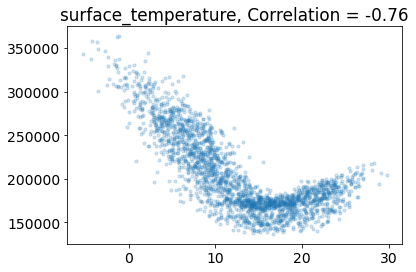

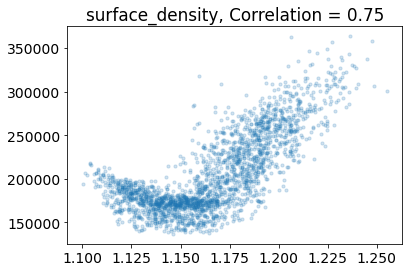

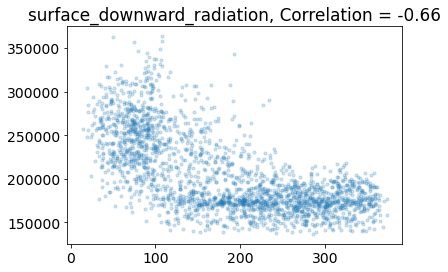

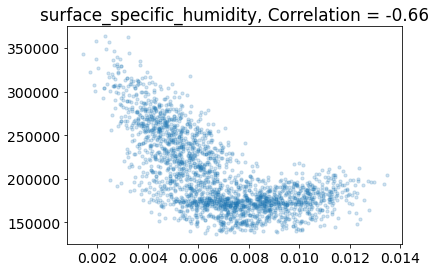

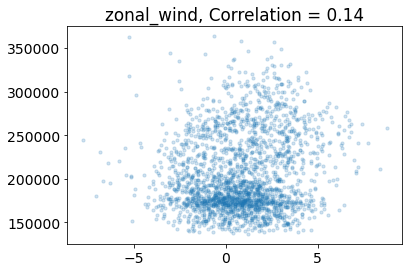

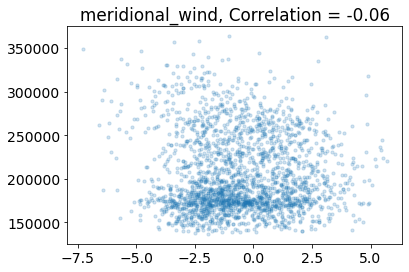

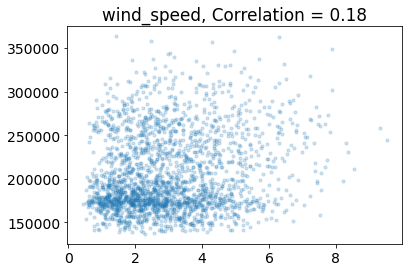

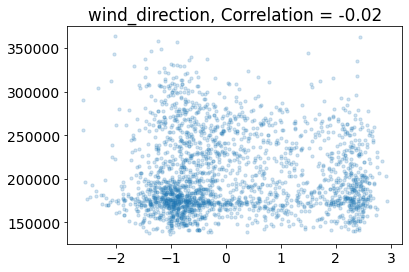

In [4]:
for variable_name, da in ds_clim_reg_day.items():
    plt.figure()
    plt.scatter(da.values, df_dem_reg_day.values, s=10, alpha=0.2)
    c = np.corrcoef(da.values, df_dem_reg_day.values)[0, 1]
    plt.title('{}, Correlation = {:.2f}'.format(variable_name, c))

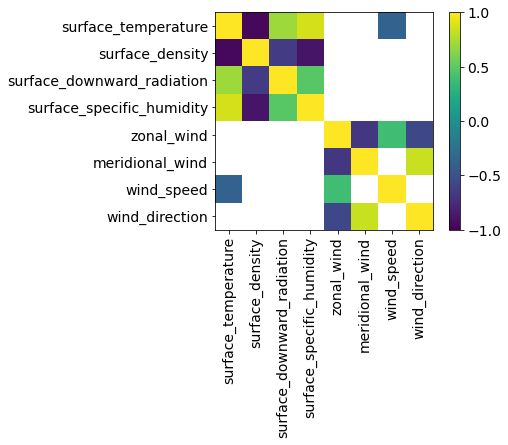

In [5]:
corr_clim = np.corrcoef(ds_clim_reg_day.to_array().values)
fig, ax = plt.subplots()
plt.imshow(np.where(np.abs(corr_clim) > 0.3, corr_clim, np.nan),
           vmin=-1., vmax=1.)
ticks = range(len(variable_names))
ticklabels = variable_names
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation=90.)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
plt.colorbar()

Answer:

### Preparing feature extraction

As in the previous tutorials, we define nonlinear features from the temperature based on heating- and cooling-temperatures.

In [6]:
# Define heating and cooling temperature thresholds
TEMP_HEAT = 16.
TEMP_COOL = 19.

# Define function returning a dictionary from variable name
# to variable train data with base, heating and cooling variables
def get_base_heat_cool(x):
    return {
        'heat': (TEMP_HEAT - x) * (x < TEMP_HEAT).astype(float),
        'cool': (x - TEMP_COOL) * (x > TEMP_COOL).astype(float)
    }

We also define a factorization by month.
In other words, for each variable, we define 12 new variables for which the values are that of the original variable for dates in the corresponding month, zero otherwise.

In [7]:
def factorize_monthly(variables, index):
    new_variables = {}
    for variable_name, variable_data in variables.items():
        for month in range(1, 13):
            new_variable_name = '{}_m{:02d}'.format(variable_name, month)
            new_variables[new_variable_name] = variable_data * (
                index.month == month).astype(float)
            
    return new_variables

### Regressions evaluation function

We also define a function to evaluate any of our regressions.

`FIRST_TEST_YEAR` controls the number of years at the end of the time series to keep as test data.

For the sake of the exercise, we also voluntarily deteriorate the training set by keeping only the first `N_TRAIN_DAYS_IN_MONTH` days in a month.
In other words, `N_TRAIN_DAYS_IN_MONTH = 1` means that the size of the training set is reduced by about 30.

This make it more likely to end up overfitting and help us illustrate the regularization effect of ensemble methods.

In [134]:
from sklearn import model_selection

# Default number of test days
FIRST_TEST_YEAR = 2018

# Number of days in month to keep for training
# (to reduce amount of available train data)
N_TRAIN_DAYS_IN_MONTH = 31

def evaluate_regressor(
    reg, reg_kwargs, param_coord, first_test_year=FIRST_TEST_YEAR,
    n_splits=None, n_train_days_in_month=N_TRAIN_DAYS_IN_MONTH,
    cv_iterator=model_selection.GroupKFold, plot_validation=True):
    # Get param name and range
    param_name = param_coord['param_name']
    param_range = param_coord['param_range']
    
    if n_splits is None:
        n_splits = len(np.unique(time[time.year < first_test_year].year))
    
    # Get test data keeping last years
    index_test = time.year >= first_test_year
    x_test = x[index_test]
    X_test = X[index_test]
    y_test = y[index_test]
    
    # Select train data from first years and first days in month 
    train_days_in_month = np.arange(1, n_train_days_in_month + 1)
    first_days = np.array([d in train_days_in_month for d in time.day])
    index_train = ((time.year < first_test_year) & first_days)
    X_train = X[index_train]
    y_train = y[index_train]
    
    # Set cross-validation iterator
    cv = cv_iterator(n_splits=n_splits)
    groups = ds_clim_reg_day.indexes['time'][index_train].year

    # Get train and validation scores from cross-validation
    train_scores, validation_scores = model_selection.validation_curve(
        reg, X_train, y_train, **param_coord, cv=cv, groups=groups)
    
    # Get train curve
    train_scores_mean = train_scores.mean(1)
    train_scores_max = train_scores.max(1)
    train_scores_min = train_scores.min(1)
    
    # Get validation curve
    validation_scores_mean = validation_scores.mean(1)
    validation_scores_max = validation_scores.max(1)
    validation_scores_min = validation_scores.min(1)

    # Get best value of the regularization parameter
    i_best = np.argmax(validation_scores_mean)
    param_best = param_range[i_best]
    score_best = validation_scores_mean[i_best]

    if plot_validation:
        # Plot validation curve
        lw = 2
        plt.figure()
        plt.semilogx(param_range, train_scores_mean, label="Training score",
                     color="darkorange", lw=lw)
        plt.fill_between(param_range, train_scores_min, train_scores_max,
                         alpha=0.2, color="darkorange", lw=lw)
        plt.semilogx(param_range, validation_scores_mean,
                     label="Cross-validation score", color="navy", lw=lw)
        plt.fill_between(
            param_range, validation_scores_min, validation_scores_max,
            alpha=0.2, color="navy", lw=lw)
        plt.xlabel(param_name)
        plt.ylabel(r'Validation $r^2$')
        plt.title(REGION_NAME + r'. Best $r^2$: {:.2} for {} = {:.1e}'.format(
            score_best, param_name, param_best))
        plt.ylim(0.0, 1.1)
        plt.legend(loc="best")

    # Compute prediction error conditioned on first 5 years of data
    reg.set_params(**{param_name: param_best})
    reg.fit(X_train, y_train)
    test_score = reg.score(X_test, y_test)
    print('\nTest r2: {:.2f}'.format(test_score))

    # Predict for work days and off days
    y_pred = reg.predict(X_test)

    # Plot prediction on top of train data versus temperature
    plt.figure()
    plt.scatter(x_test, y_test, s=10, alpha=0.5)
    plt.scatter(x_test, y_pred, s=10)
    plt.xlabel(temp_label)
    plt.ylabel(dem_label)
    plt.title(REGION_NAME)

    # Scatter plot of prediction against target
    plt.figure()
    plt.scatter(y_test, y_pred, s=10, alpha=0.5)
    plt.xlabel('Target ' + dem_label)
    plt.ylabel('Predicted ' + dem_label)
    plt.title(REGION_NAME)
    
    return {param_name: param_best}

### Feature selection

The following code select features, by controlling:
- The climate variables to add to heating- and cooling-temperatures;
- The degree of polynomial interactions.

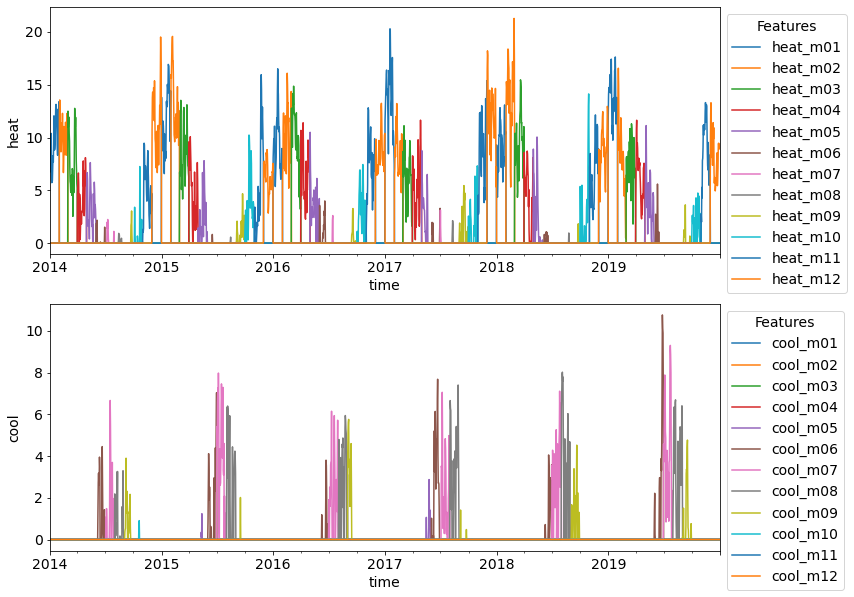

In [125]:
from sklearn import preprocessing

# Variables in addition to temperature features
ADDITIONAL_VARIABLE_NAMES = []
# ADDITIONAL_VARIABLE_NAMES = [
#     'surface_density', 'surface_downward_radiation',
#     'surface_specific_humidity', 'wind_speed', 'wind_direction'
# ]

# Degree of polynomial interactions
POLY_DEGREE = 1

# Get features
clim_time = ds_clim_reg_day.indexes['time']
x = ds_clim_reg_day['surface_temperature'].values
y = df_dem_reg_day.values
features = get_base_heat_cool(x)
for var_name in ADDITIONAL_VARIABLE_NAMES:
    features[var_name] = ds_clim_reg_day[var_name].values
feature_names_nofact = list(features)
features = factorize_monthly(features, clim_time)
feature_names = list(features)

df_features = pd.DataFrame(features, index=clim_time)
n_feat_nofact = len(feature_names_nofact)
fig, axs = plt.subplots(n_feat_nofact, figsize=[12, 5 * n_feat_nofact])
for k, feature_name in enumerate(feature_names_nofact):
    try:
        ax = axs[k]
    except TypeError:
        ax = axs
    feat_variables = [feature_name in v for v in feature_names]
    df_features.iloc[:, feat_variables].plot(ax=ax, ylabel=feature_name)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', title='Features')

# Get input matrix
X = np.array(list(features.values())).T
if POLY_DEGREE > 1:
    poly = preprocessing.PolynomialFeatures(POLY_DEGREE)
    X =  poly.fit_transform(X)


Test r2: 0.85


<AxesSubplot:>

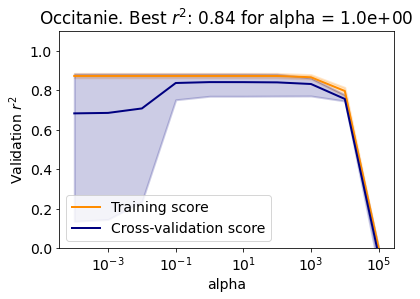

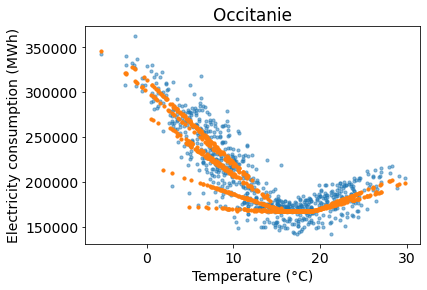

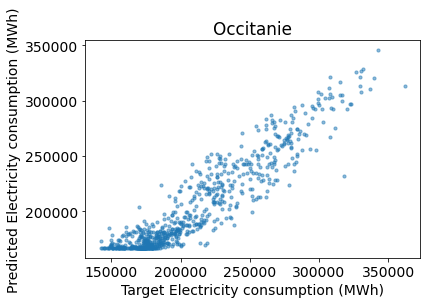

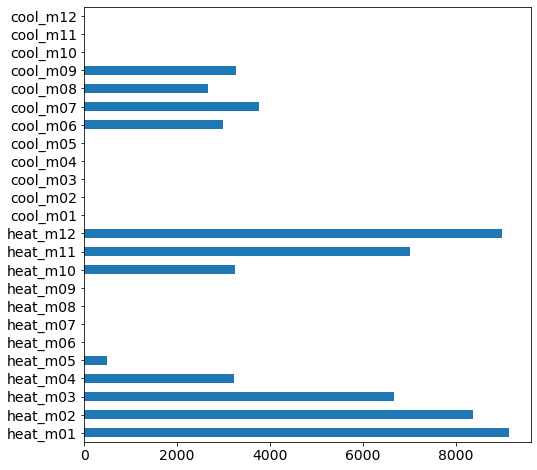

In [136]:
from sklearn import linear_model

# Define array of complexity coordinate, regressor and options
# for Lasso regression
param_name, param_range = 'alpha', np.logspace(-4, 5, 10)
param_coord_lasso = {'param_name': param_name, 'param_range': param_range}
reg_kwargs_lasso = dict(fit_intercept=True, warm_start=True,
                        positive=True, max_iter=1e4)
reg_lasso = linear_model.Lasso(
    **{param_name: param_range[0]}, **reg_kwargs_lasso)

# Evaluate regressor
param_best_lasso = evaluate_regressor(
    reg_lasso, reg_kwargs_lasso, param_coord_lasso)
df_coef = pd.Series(reg_lasso.coef_, index=feature_names)
plt.figure()
df_coef.plot(kind='barh', figsize=(8, 8))


Test r2: 0.86


<AxesSubplot:>

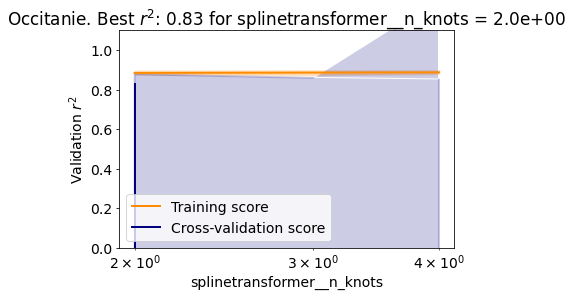

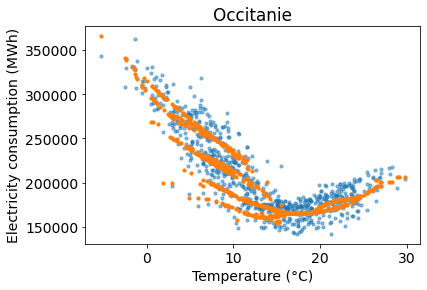

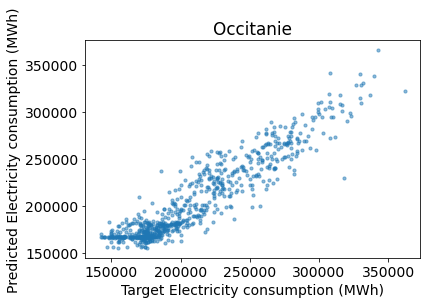

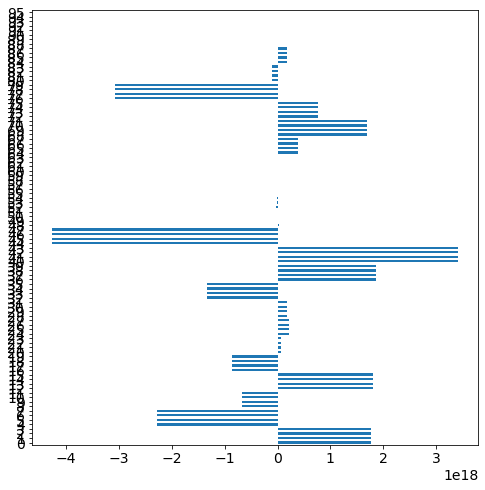

In [145]:
from sklearn import pipeline

# Define array of complexity coordinate, regressor and options
# for splines regression
param_name, param_range = 'splinetransformer__n_knots', np.arange(3) + 2
param_coord_sl = {'param_name': param_name, 'param_range': param_range}
reg_kwargs_sl = dict()
linear_reg = linear_model.LinearRegression()
reg_sl = pipeline.make_pipeline(
    preprocessing.SplineTransformer(n_knots=3, degree=3), linear_reg)

# Evaluate regressor
param_best_sl = evaluate_regressor(
    reg_sl, reg_kwargs_sl, param_coord_sl)
df_coef = pd.Series(reg_sl[1].coef_)
plt.figure()
df_coef.plot(kind='barh', figsize=(8, 8))


Test r2: 0.78


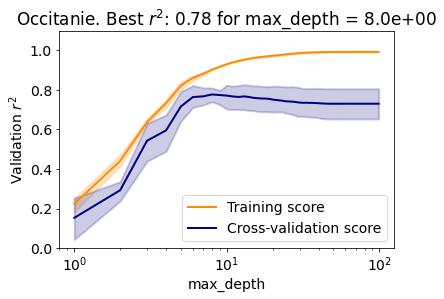

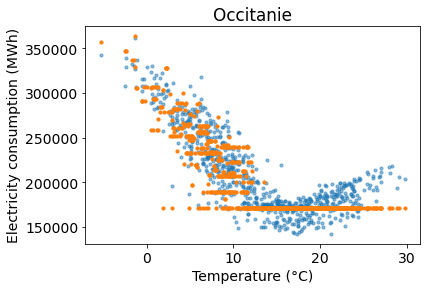

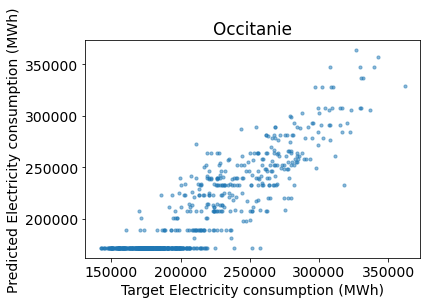

In [128]:
from sklearn import tree

# Define array of complexity coordinate, regressor and options
# for nearest-neighbors regression
param_coord_dt = {'param_name': 'max_depth',
                  'param_range': np.arange(1, 100, 1)}
reg_class_dt = tree.DecisionTreeRegressor
reg_kwargs_dt = dict()

# Evaluate regressor
param_best_dt, reg_dt = evaluate_regressor(
    reg_class_dt, reg_kwargs_dt, param_coord_dt)


Test r2: 0.81


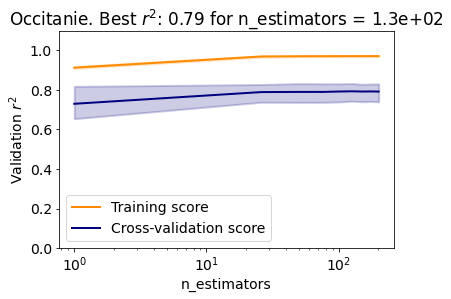

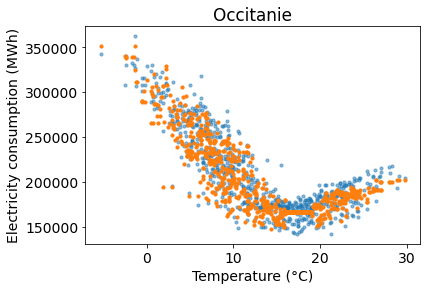

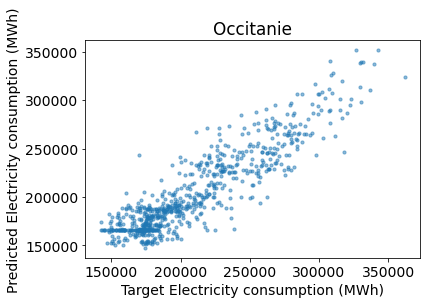

In [126]:
from sklearn import ensemble

# Define array of complexity coordinate, regressor and options
# for random-forest regression
param_coord_rf = {'param_name': 'n_estimators',
                  'param_range': np.arange(1, 202, 25)}
reg_class_rf = ensemble.RandomForestRegressor
reg_kwargs_rf = dict()

# Evaluate regressor
param_best_rf, reg_rf = evaluate_regressor(
    reg_class_rf, reg_kwargs_rf, param_coord_rf)

Text(0, 0.5, 'Mean decrease in impurity')

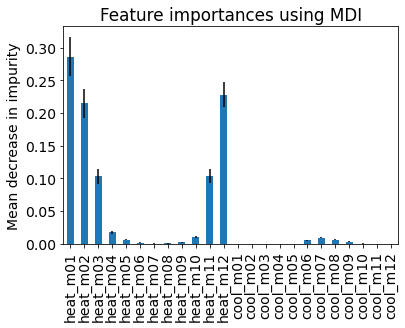

In [127]:
# Plot importance
importances = reg_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


Test r2: 0.83


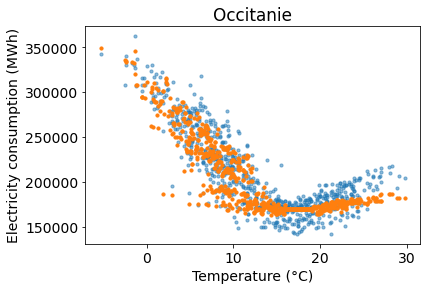

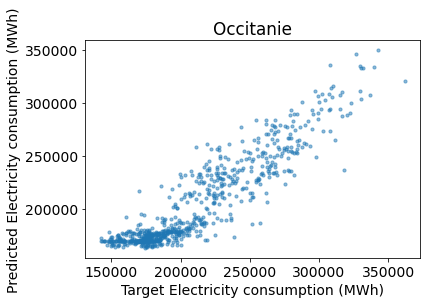

In [130]:
# Define array of complexity coordinate, regressor and options
# for random-forest regression
param_coord_vr = {'param_name': 'estimators',
                  'param_range': [[('Lasso', reg_lasso),
                                   ('DecisionTree', reg_dt),
                                   ('RandomForest', reg_rf)]]}
reg_class_vr = ensemble.VotingRegressor
reg_kwargs_vr = dict()

# Evaluate regressor
param_best_vr, reg_vr = evaluate_regressor(
    reg_class_vr, reg_kwargs_vr, param_coord_vr, plot_validation=False)

In [ ]:
# Define array of complexity coordinate, regressor and options
# for AdaBoost regression
param_coord_abr = {'param_name': 'n_estimators',
                  'param_range': np.arange(1, 50, 2)}
reg_class_abr = ensemble.AdaBoostRegressor
base_estimator = linear_model.LinearRegression(fit_intercept=True)
reg_kwargs_abr = dict(base_estimator=base_estimator)

# Evaluate regressor
param_best_abr, reg_abr = evaluate_regressor(
    reg_class_abr, reg_kwargs_abr, param_coord_abr)

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>